In [1]:
# Making mount with the google drive
import google.colab
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%%shell
pip install cython
pip install gdown
pip install googledrivedownloader
import PIL
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

/bin/bash: line 3: import: command not found
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-e6fyub5m
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-e6fyub5m
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275297 sha256=d2d608f13c1d70d4be95566539d7d9c6902a63fa1afc798c739f09b2f9d8b17a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0a9enxu/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [3]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git  #downloading
cd vision # Going inside
git checkout v0.8.5  # After a couple of attempts this is the chosen version
#Copy one folder back ../
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
error: pathspec 'v0.8.5' did not match any file(s) known to git.


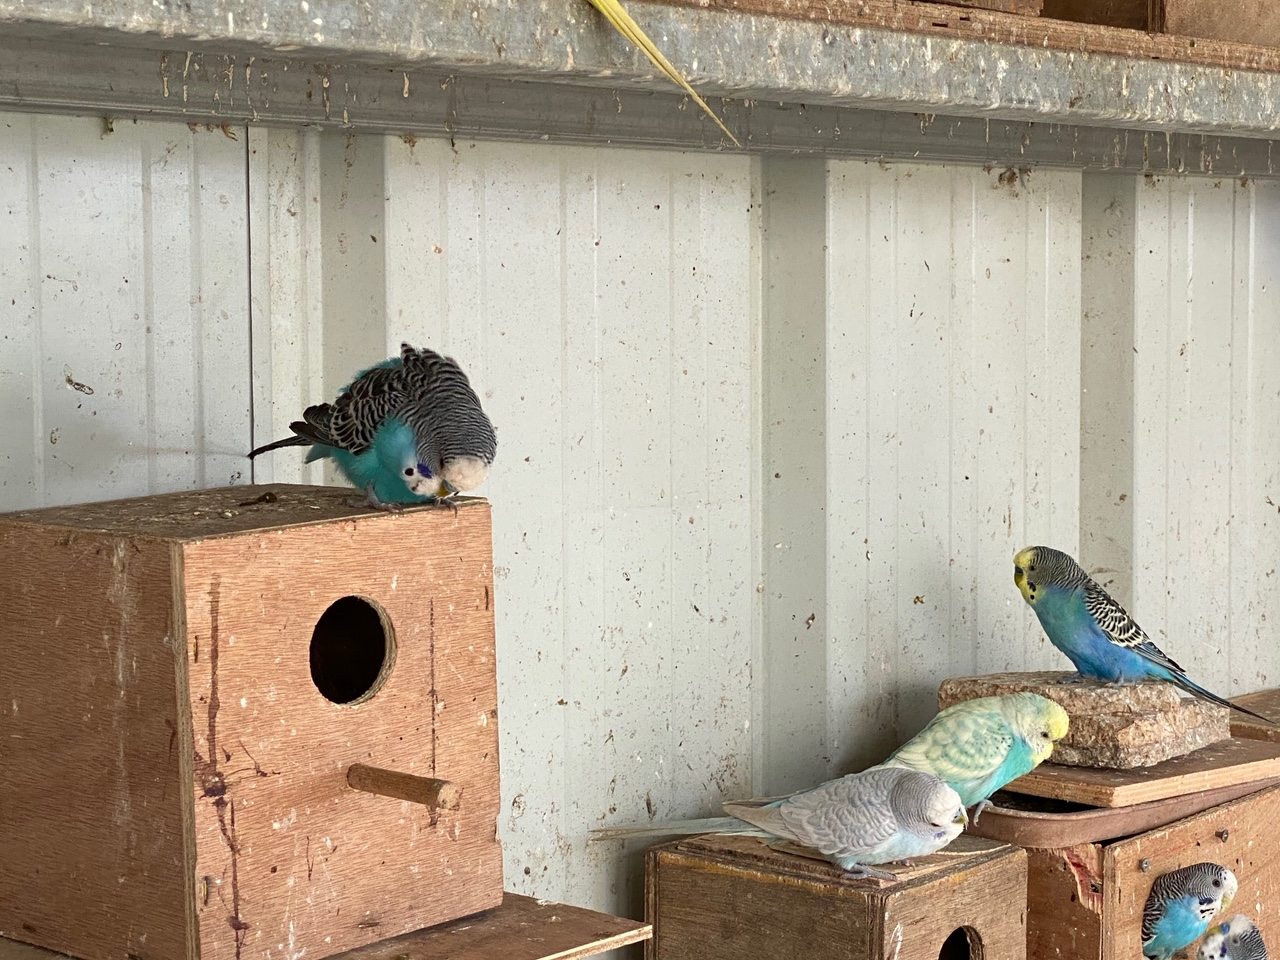

In [4]:
from IPython.display import Image, display
display(Image('../gdrive/My Drive/BirdsData/BirdsGideon/IMG_3156.jpg', unconfined=True))

# import glob
# print(glob.glob("gdrive/My Drive/*"))

In [5]:
from IPython import embed
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
import requests
from io import BytesIO
import urllib
from os import path

# Read JSON for the masking part
# with open('../gdrive/My Drive/BirdsData/BirdsGideon/file1.json') as f:
#     data = json.load(f)

with open('../gdrive/My Drive/BirdsData/BirdsGideon/file2.json') as f:
    data = json.load(f)

imgs,masks = [], []
for row in data:
    # image
    img_url = row['Labeled Data']
    
    fname = row['ID']
    urllib.request.urlretrieve(img_url, fname)
    img = Image.open(fname)
    img = img.convert("RGB")
    
    w,h = img.size
    RS = 3  # reducing the image size by
    img = img.resize((w//RS,h//RS))
    
    imgs.append(img)
    
    l = []
    # masks
    for object in row['Label']['objects']:
        mask_url = object['instanceURI']

        fname = object['featureId']
        urllib.request.urlretrieve(mask_url, fname)
        mask = Image.open(fname)
        mask = mask.convert("L")

        w,h = mask.size
        mask = mask.resize((w//RS,h//RS))
        
        mask = np.array(mask)
        
        l.append(mask)
    masks.append(l)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<class 'dict'>
The are 3 objects


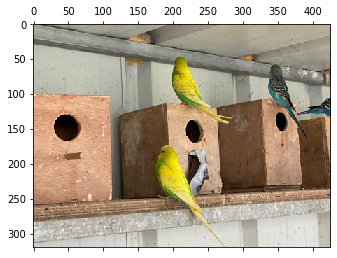

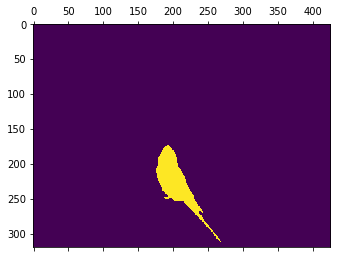

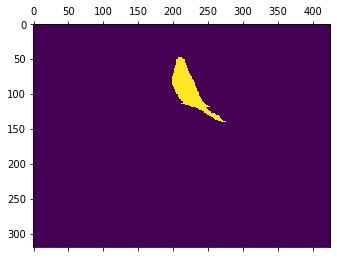

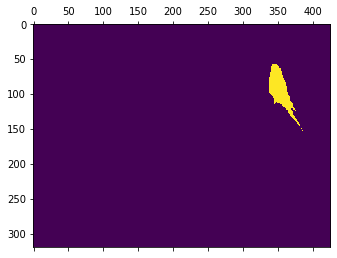

In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# Class for the Birds dataset
class BirdsDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, train):
        self.imgs = imgs
        self.masks = masks
        self.train = train

    def __getitem__(self, idx):
        img = self.imgs[idx]
        masks = self.masks[idx]

        # Getting Bounding-box coordinates for each mask
        num_objs = len(masks)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Note that there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8) / 255

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        transforms = []
        transforms.append(T.ToTensor())
        if self.train:
            transforms.append(T.RandomHorizontalFlip(0.5))
        transform = T.Compose(transforms)

        img, target = transform(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

dataset = BirdsDataset(imgs, masks, train=True)
img, target = dataset[0]

import matplotlib.pyplot as plt
plt.matshow(img.permute(1,2,0))

print(type(target))

until = len(target["labels"])

for i in range(until):
  plt.matshow(target['masks'][i,:,:])

# How many objects are there
print('The are', until, 'objects')

##Attempts
# torch.Size([100, 1, 246, 328])
# Image.fromarray(summed[0].mul(255).byte().cpu().numpy())
# Image.fromarray(prediction[0]['masks'][4, 0].mul(255).byte().cpu().numpy())
# summed = torch.sum(prediction[0]['masks'],0)
# Image.fromarray(summed[0].mul(255).byte().cpu().numpy())

# boxes = target['boxes'].tolist()
# # type: (Tensor, List[Tensor])
# assert isinstance(boxes, (list, tuple))
# assert isinstance(rel_codes, torch.Tensor)
# boxes_per_image = [b.size(0) for b in boxes]
# concat_boxes = torch.cat(boxes, dim=0)
# box_sum = 0
# for val in boxes_per_image:
#     box_sum += val
# pred_boxes = self.decode_single(
#     rel_codes.reshape(box_sum, -1), concat_boxes
# )
# return pred_boxes.reshape(box_sum, -1, 4)


In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# We want to fine-tune from a pre-trained model, given that our dataset is very small.
# So we will be follow the next - Start from a model pre-trained on COCO and
# we will finetune it for our particular classes and
# Since we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
# Using the dataset and definding the augmentation
dataset = BirdsDataset(imgs, masks, train=True)
dataset_test = BirdsDataset(imgs, masks, train=False)

# Splitting the dataset - in TRAIN and TEST set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
print("length before division into train & test:",len(dataset))
dataset = torch.utils.data.Subset(dataset, indices[0:(len(indices)-1)]) # Note: Change 1 to 4 to see all the options and the difference
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1:]) # The last one is for TESTTING
print("train:",len(dataset))
print("test:",len(dataset_test))

# Defining TRAINING and VALIDATION data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)

length before division into train & test: 3
train: 2
test: 1


In [9]:
from coco_eval import CocoEvaluator

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataset has only two classes: [1]background [2]parrot
num_classes = 2

# Getting the model using our HELPER FUNCTION
model = get_instance_segmentation_model(num_classes)
# Moving the model to the right device
model.to(device)

# Construct an OPTIMIZER
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0)

# Learning rate scheduler which decreases the learning rate by 10x every 40 EPOCHS
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=40,
                                               gamma=0.1)

# Training it for 90 epochs
num_epochs = 90

loss = []
for epoch in range(num_epochs):
    # Training for one EPOCH, printing every 90 ITERATIONS
    metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    loss.append(metric_logger.loss.avg) #Adding to the list
    # Updating the learning rate
    lr_scheduler.step()
    # Evaluating on the test dataset
    evaluate(model, data_loader_test, device=device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



Epoch: [0]  [0/2]  eta: 0:00:02  lr: 0.005000  loss: 5.9615 (5.9615)  loss_classifier: 0.6826 (0.6826)  loss_box_reg: 0.4215 (0.4215)  loss_mask: 4.7746 (4.7746)  loss_objectness: 0.0525 (0.0525)  loss_rpn_box_reg: 0.0303 (0.0303)  time: 1.4889  data: 0.1206  max mem: 1206
Epoch: [0]  [1/2]  eta: 0:00:01  lr: 0.005000  loss: 5.6963 (5.8289)  loss_classifier: 0.6826 (0.6917)  loss_box_reg: 0.4215 (0.4811)  loss_mask: 4.3633 (4.5689)  loss_objectness: 0.0525 (0.0564)  loss_rpn_box_reg: 0.0303 (0.0307)  time: 1.0254  data: 0.1211  max mem: 1583
Epoch: [0] Total time: 0:00:02 (1.0283 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:00  model_time: 0.2478 (0.2478)  evaluator_time: 0.0628 (0.0628)  time: 0.3514  data: 0.0400  max mem: 1583
Test: Total time: 0:00:00 (0.3519 s / it)
Averaged stats: model_time: 0.2478 (0.2478)  evaluator_time: 0.0628 (0.0628)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 

Text(0, 0.5, 'Loss')

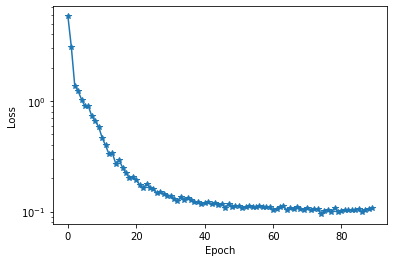

In [10]:
#print a graph of EPOCH and LOSS
plt.figure()
plt.semilogy(loss,'-*')
plt.xlabel('Epoch')
plt.ylabel('Loss')

train


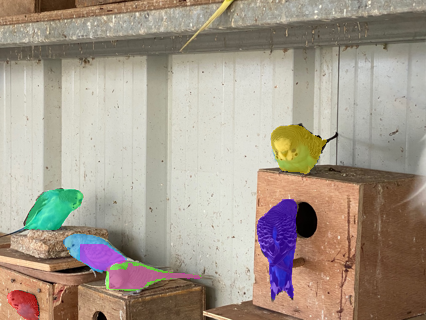

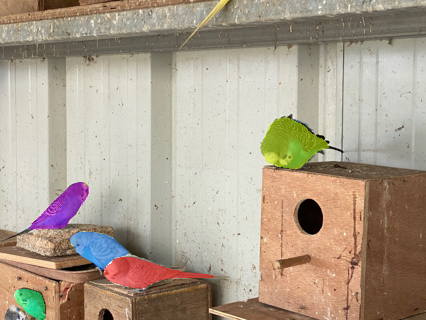

test


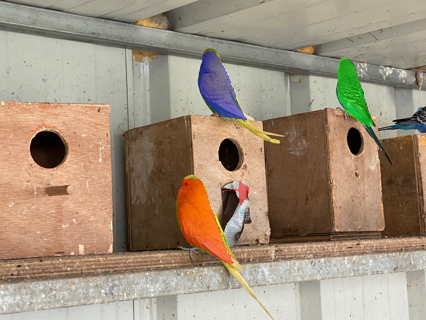

In [11]:
import random
import colorsys

# Making masks on each parrot - using probability 0.5
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[c] = torch.where(mask > 0.5,
                            image[c] * (1 - alpha) + alpha * color[c],
                            image[c])
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


# Putting the model in evaluation mode
model.eval()

for phase in ['train','test']:
    print(phase)

    if phase == 'train':
        loader = data_loader
    elif phase == 'test':
        loader = data_loader_test
    
    for batch in loader:
      img = batch[0][0]

      with torch.no_grad():
          prediction = model([img.to(device)])
      
      img = img.cpu()
      masks = prediction[0]['masks'].cpu()

      N = masks.shape[0]
      colors = random_colors(N)
      for i in range(N):
          img = apply_mask(img, masks[i], colors[i], alpha=0.5)
      display(Image.fromarray(img.mul(255).byte().permute(1, 2, 0).numpy()))